## By graf

## Visualiser graf

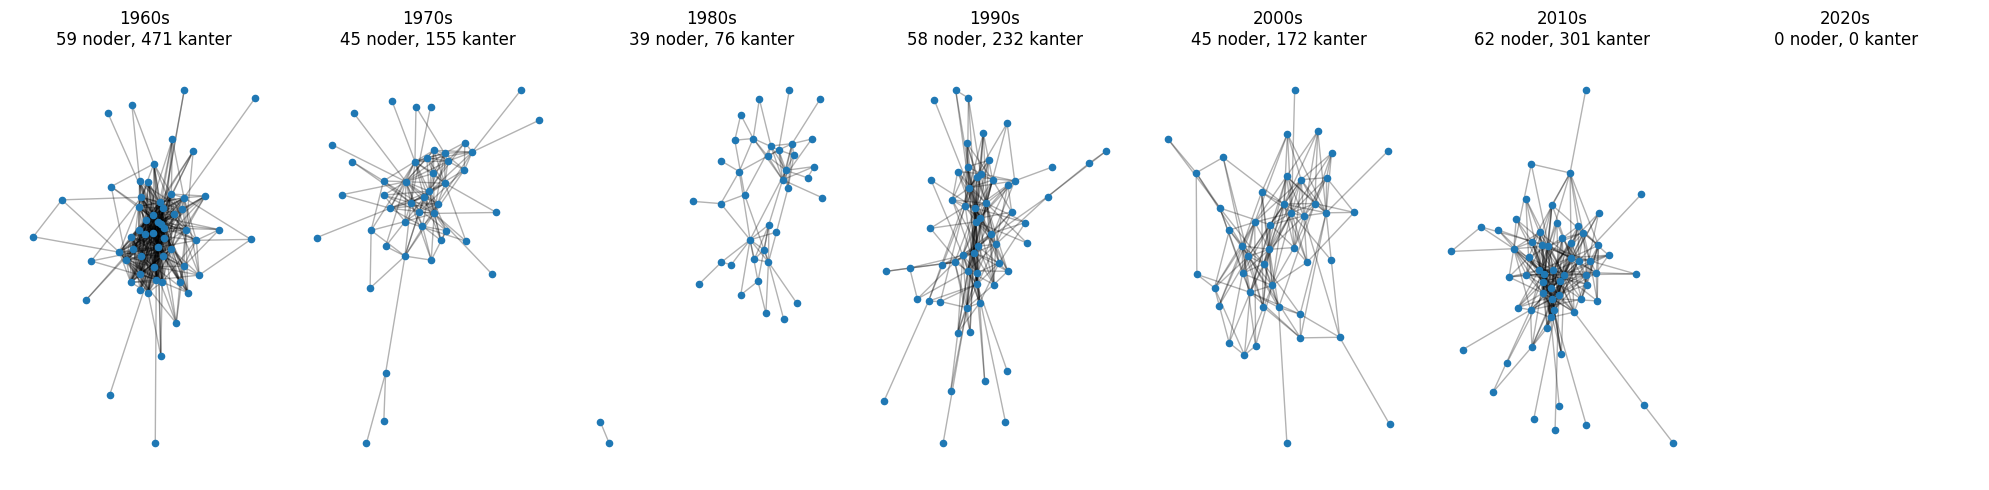

In [20]:
import matplotlib.pyplot as plt
import networkx as nx

# Listen af dekader du har grafer for
decades = ['1960s','1970s','1980s','1990s','2000s','2010s','2020s']

# Opret en figur med én kolonne per dekade
fig, axes = plt.subplots(1, len(decades), figsize=(20, 5))

for ax, decade in zip(axes, decades):
    G = artist_graphs.get(decade, nx.Graph())
    # Beregn layout kun én gang per graf
    pos = nx.spring_layout(G, seed=42)
    # Tegn noder og kanter
    nx.draw_networkx_nodes(G, pos, node_size=20, ax=ax)
    nx.draw_networkx_edges(G, pos, alpha=0.3, ax=ax)
    # Titel med node- og kant-antal
    ax.set_title(f"{decade}\n{G.number_of_nodes()} noder, {G.number_of_edges()} kanter")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [57]:
GENIUS_TOKEN = "9p_BD8jn6Vn2UIZ-3ZRBBXRQlQAuRCJ2PtJ1tzRuTuZmkfVeNHCeMfAbeo7qpI3MeBdI91LsfAaxil1AvwNllw"

In [73]:
import os
import time
import re
import requests
import pandas as pd
import numpy as np
import networkx as nx
import community as community_louvain
from itertools import combinations
from collections import Counter, defaultdict
from wordcloud import WordCloud
from bs4 import BeautifulSoup
import lyricsgenius
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import random
import json
import csv

# random.seed(42)

In [4]:
DATADIR         = "../../datadump"
OUT_SONGS_DIR   = "med_20_sange/community_songs"
OUT_LYRICS_DIR  = "med_20_sange/community_lyrics"
OUT_WC_DIR      = "med_20_sange/community_wordclouds"
for d in (OUT_SONGS_DIR, OUT_LYRICS_DIR, OUT_WC_DIR):
    os.makedirs(d, exist_ok=True)

songs = (
    pd.read_csv(f"{DATADIR}/songs_no_dublicates.csv",
                usecols=['recording_mbid','title','artist_mbid','first_release_year'])
    .sort_values('first_release_year')
    .drop_duplicates('recording_mbid', keep='first')
)
writes = pd.read_csv(f"{DATADIR}/writerships.csv",
                     usecols=['recording_mbid','writer_id'])
artists = pd.read_csv(f"{DATADIR}/artists_all.csv",
                      usecols=['artist_mbid','name'])
id_to_name = artists.set_index('artist_mbid')['name'].to_dict()


In [76]:
# ─── 1) Beregn hvert artists første‐udgivelses‐årti ────────────────
artist_first_year = (
    songs
    .groupby('artist_mbid')['first_release_year']
    .min()
    .dropna()
)
# Rund ned til tiåret
artist_decade_map = (artist_first_year // 10 * 10).astype(int).to_dict()


# ─── 2) Funktion der bygger artist–artist‐graf for et givent årti ──
def build_artist_graph_earliest(decade_start):
    decade_end = decade_start + 9

    # A) tag alle sange udgivet i dét tiår
    dec_songs = songs[
        songs['first_release_year'].between(decade_start, decade_end) &
        (songs['artist_mbid'].map(artist_decade_map) == decade_start)
    ]
    rec2art = dict(zip(dec_songs.recording_mbid, dec_songs.artist_mbid))

    # B) filtrer writerships til de recordings
    writes_sub = writes[writes.recording_mbid.isin(rec2art)]

    # C) akkumuler artist‐par pr. writer og husk writers på hver kant
    pair_counter = Counter()
    edge_writers = defaultdict(set)
    for writer_id, grp in writes_sub.groupby('writer_id'):
        artists = sorted({ rec2art[r] for r in grp.recording_mbid })
        if len(artists) < 2:
            continue
        for a1, a2 in combinations(artists, 2):
            pair_counter[(a1, a2)] += 1
            edge_writers[(a1, a2)].add(writer_id)

    # D) byg grafen med vægt og writer-liste på kanten
    G = nx.Graph()
    for (a1, a2), w in pair_counter.items():
        G.add_edge(a1, a2,
                   weight=w,
                   writers=list(edge_writers[(a1, a2)]))
    return G


# ─── 3) Eksempel: byg grafer for 1960s–2020s og print stats ─────────
artist_graphs_earliest = {}
for start in range(1960, 2030, 10):
    label = f"{start}s"
    G = build_artist_graph_earliest(start)
    artist_graphs_earliest[label] = G
    print(f"{label}: {G.number_of_nodes():>4} noder  | {G.number_of_edges():>6} kanter")

1960s:   59 noder  |    471 kanter
1970s:   45 noder  |    155 kanter
1980s:   39 noder  |     76 kanter
1990s:   58 noder  |    232 kanter
2000s:   45 noder  |    172 kanter
2010s:   62 noder  |    301 kanter
2020s:    0 noder  |      0 kanter


In [7]:
# Indlæs artist‐lookup og byg dict: artist_mbid → navn
artist_lookup = pd.read_csv('../../datadump/artists_all.csv',
                           usecols=['artist_mbid','name'],
                           dtype=str)
artist_dict = artist_lookup.set_index('artist_mbid')['name'].to_dict()

In [74]:
input_dir = "../../public/udgivelsesår"
output_dir = "../../public/udgivelsesår"
os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir(input_dir):
    if filename.endswith(".json"):
        with open(os.path.join(input_dir, filename), "r", encoding="utf-8") as f:
            data = json.load(f)

        decade = filename.replace(".json", "")
        output_path = os.path.join(output_dir, f"{decade}.csv")

        with open(output_path, "w", newline="", encoding="utf-8") as out:
            writer = csv.writer(out)
            writer.writerow(["artist_mbid", "artist_name", "community"])
            for node in data["nodes"]:
                writer.writerow([node["id"], node["name"], node["community"]])


import re

def load_communities_from_csv(folder):
    decade2comm = {}
    for filename in os.listdir(folder):
        if filename.endswith(".csv"):
            match = re.search(r"(\d{4}s)", filename)  # matcher fx '1960s'
            if not match:
                continue
            decade = match.group(1)

            df = pd.read_csv(os.path.join(folder, filename))
            comm2nodes = defaultdict(list)
            for _, row in df.iterrows():
                comm2nodes[row["community"]].append(row["artist_mbid"])
            decade2comm[decade] = comm2nodes
    return decade2comm

all_comm2nodes_peak = load_communities_from_csv("../../public/udgivelsesår_csv")

In [77]:
CANDIDATE_SONGS = 40
TARGET_LYRICS   = 20
DATADIR         = "../../datadump"
OUT_DIR         = "community_lyrics_ovh"
os.makedirs(OUT_DIR, exist_ok=True)
id_to_name = artists.set_index('artist_mbid')['name'].to_dict()

# ─── 3) HJÆLPEFUNKTIONER ──────────────────────────────────────────────────────
def fetch_lyrics_ovh(artist: str, title: str) -> str:
    url = f"https://api.lyrics.ovh/v1/{requests.utils.quote(artist)}/{requests.utils.quote(title)}"
    try:
        r = requests.get(url, timeout=5)
        if r.status_code == 200:
            return r.json().get("lyrics", "")
    except Exception:
        pass
    return ""

def clean_lyrics(text: str) -> str:
    text = re.sub(r"\[.*?\]", "", text)
    text = re.sub(r"^[A-Za-z0-9 ]+:\s*", "", text, flags=re.MULTILINE)
    lines = [ln.strip() for ln in text.splitlines() if ln.strip()]
    return "\n".join(lines)

# ─── 4) LOOP OVER COMMUNITIES & HENT LYRICS ─────────────────────────────────
for decade, G in artist_graphs_earliest.items():
    comm2nodes = all_comm2nodes_peak.get(decade, {})
    if not comm2nodes:
        continue

    for comm_id, members in comm2nodes.items():
        label = f"{decade}_comm{comm_id}"
        print(f"\n▶ Behandler {label}: {len(members)} artister")

        # A) Byg per‐artist liste over “forbundne” writers
        eligible_writers = defaultdict(set)
        for u, v, data in G.edges(data=True):
            if u in members and v in members and "writers" in data:
                for w in data["writers"]:
                    eligible_writers[u].add(w)
                    eligible_writers[v].add(w)

        # B) Filtrér sange
        df = (
            writes
            .merge(songs[['recording_mbid','title','artist_mbid']],
                   on='recording_mbid', how='inner')
        )
        df = df[df['artist_mbid'].isin(members)]
        mask = df.apply(lambda row: row['writer_id'] in eligible_writers[row['artist_mbid']], axis=1)
        df = df[mask]

        df_songs = df[['recording_mbid','title','artist_mbid']].drop_duplicates('recording_mbid')
        if df_songs.empty:
            print("   ⚠ Ingen sange opfylder de nye, skærpede kriterier – springer over.")
            continue

        # C) Hent lyrics løbende indtil vi har 20
        rows = []
        seen_recordings = set()
        while len(rows) < TARGET_LYRICS and len(seen_recordings) < len(df_songs):
            remaining = df_songs[~df_songs['recording_mbid'].isin(seen_recordings)]
            if remaining.empty:
                break
            row = remaining.sample(n=1, random_state=int(time.time())).iloc[0]
            seen_recordings.add(row['recording_mbid'])

            artist_name = id_to_name.get(row['artist_mbid'], "")
            title_clean = re.sub(r"\s*\(.*?\)", "", row['title']).strip()
            raw = fetch_lyrics_ovh(artist_name, title_clean)
            lyric = clean_lyrics(raw)
            if lyric:
                rows.append({
                    "recording_mbid": row["recording_mbid"],
                    "title":          row["title"],
                    "artist_name":    artist_name,
                    "lyrics":         lyric
                })
            time.sleep(1)

        # D) Gem lyrics
        out = pd.DataFrame(rows)
        path = os.path.join(OUT_DIR, f"{label}_lyrics.csv")
        out.to_csv(path, index=False, encoding="utf-8")
        print(f"   ✅ Gemt {len(rows)} lyrics i {path}")


▶ Behandler 1960s_comm0: 16 artister
   ✅ Gemt 20 lyrics i community_lyrics_ovh/1960s_comm0_lyrics.csv

▶ Behandler 1960s_comm1: 13 artister
   ✅ Gemt 20 lyrics i community_lyrics_ovh/1960s_comm1_lyrics.csv

▶ Behandler 1960s_comm2: 21 artister
   ✅ Gemt 20 lyrics i community_lyrics_ovh/1960s_comm2_lyrics.csv

▶ Behandler 1960s_comm3: 9 artister
   ✅ Gemt 20 lyrics i community_lyrics_ovh/1960s_comm3_lyrics.csv

▶ Behandler 1970s_comm0: 10 artister
   ✅ Gemt 20 lyrics i community_lyrics_ovh/1970s_comm0_lyrics.csv

▶ Behandler 1970s_comm1: 8 artister
   ✅ Gemt 20 lyrics i community_lyrics_ovh/1970s_comm1_lyrics.csv

▶ Behandler 1970s_comm2: 6 artister
   ✅ Gemt 20 lyrics i community_lyrics_ovh/1970s_comm2_lyrics.csv

▶ Behandler 1970s_comm3: 7 artister
   ✅ Gemt 20 lyrics i community_lyrics_ovh/1970s_comm3_lyrics.csv

▶ Behandler 1970s_comm5: 11 artister
   ✅ Gemt 20 lyrics i community_lyrics_ovh/1970s_comm5_lyrics.csv

▶ Behandler 1970s_comm4: 3 artister
   ✅ Gemt 0 lyrics i community_

In [65]:
import os
import pandas as pd
import re
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

LYRICS_DIR = "community_lyrics_ovh"
OUT_WC_FREQ = "wordclouds_frequency"
os.makedirs(OUT_WC_FREQ, exist_ok=True)

# indlæs alle community‐filer
for fname in os.listdir(LYRICS_DIR):
    if not fname.endswith("_lyrics.csv"):
        continue
    label = fname.replace("_lyrics.csv","")
    df = pd.read_csv(os.path.join(LYRICS_DIR, fname))
    # slå alle lyrics sammen til ét dokument
    text = "\n".join(df["lyrics"].fillna(""))
    # rens kun alfanumerisk
    tokens = re.findall(r"\b\w{3,}\b", text.lower())
    freq = Counter(tokens)
    common = {w:c for w,c in freq.most_common(100)}
    # lav cloud
    wc = WordCloud(width=800, height=400, background_color="white")\
         .generate_from_frequencies(common)
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Frequency WordCloud: {label}")
    plt.savefig(f"{OUT_WC_FREQ}/{label}_freq.png", dpi=150, bbox_inches="tight")
    plt.close()

In [79]:
import os
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

LYRICS_DIR = "community_lyrics_ovh"
OUT_WC_TFIDF = "wordclouds_tfidf"
os.makedirs(OUT_WC_TFIDF, exist_ok=True)

nltk.download("stopwords", quiet=True)
STOP = stopwords.words("english")

for fname in os.listdir(LYRICS_DIR):
    if not fname.endswith("_lyrics.csv"): continue
    label = fname.replace("_lyrics.csv","")
    file_path = os.path.join(LYRICS_DIR, fname)
    if os.stat(file_path).st_size == 0:
        print(f"Skipping empty file: {fname}")
        continue
    try:
        df = pd.read_csv(file_path)
    except pd.errors.EmptyDataError:
        print(f"Skipping file with no data: {fname}")
        continue
    docs = df["lyrics"].fillna("").tolist()

    # simpel rens og stop‐liste
    def clean(txt):
        txt = re.sub(r"[^\w\s]"," ", txt.lower())
        return txt

    docs = [clean(d) for d in docs]
    vec = TfidfVectorizer(stop_words=STOP,
                          max_features=50,
                          token_pattern=r"(?u)\b\w\w+\b")
    X = vec.fit_transform(docs)
    terms = vec.get_feature_names_out()
    scores = X.sum(axis=0).A1
    freqs = dict(zip(terms, scores))

    wc = WordCloud(width=800, height=400, background_color="white")\
         .generate_from_frequencies(freqs)
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"TF–IDF WordCloud: {label}")
    plt.savefig(f"{OUT_WC_TFIDF}/{label}_tfidf.png", dpi=150, bbox_inches="tight")
    plt.close()

Skipping file with no data: 1970s_comm4_lyrics.csv


In [74]:
import networkx as nx
import pandas as pd

rows = []
for decade, G in artist_graphs_earliest.items():
    if G.number_of_nodes()==0:
        continue

    comps = list(nx.connected_components(G))
    largest = max(comps, key=len)
    G0 = G.subgraph(largest)

    rows.append({
        "decade": decade,
        "n_nodes":       G.number_of_nodes(),
        "n_edges":       G.number_of_edges(),
        "avg_degree":    sum(dict(G.degree()).values())/G.number_of_nodes(),
        "density":       nx.density(G),
        "avg_clust":     nx.average_clustering(G, weight="weight"),
        "n_comps":       nx.number_connected_components(G),
        "largest_comp":  len(largest),
        "diameter":      nx.diameter(G0) if G0.number_of_nodes()>1 else 0,
        "avg_shortest":  nx.average_shortest_path_length(G0) if G0.number_of_nodes()>1 else 0
    })

stats_df = pd.DataFrame(rows)
stats_df.to_csv("network_summary_per_decade.csv", index=False)
print(stats_df)

  decade  n_nodes  n_edges  avg_degree   density  avg_clust  n_comps  \
0  1960s       59      471   15.966102  0.275278   0.038031        1   
1  1970s       45      155    6.888889  0.156566   0.104373        1   
2  1980s       39       76    3.897436  0.102564   0.151594        2   
3  1990s       58      232    8.000000  0.140351   0.085732        1   
4  2000s       45      172    7.644444  0.173737   0.098461        1   
5  2010s       62      301    9.709677  0.159175   0.087871        1   

   largest_comp  diameter  avg_shortest  
0            59         4      1.876680  
1            45         5      2.360606  
2            37         5      2.683183  
3            58         6      2.308530  
4            45         5      2.243434  
5            62         5      2.232152  


In [82]:
import pandas as pd

# Indlæs kun de kolonner, du behøver
artist_lookup = pd.read_csv(
    '../../datadump/artists_all.csv',
    usecols=['artist_mbid', 'name'],
    dtype=str
)

# Lav dict: mbid → navn
artist_dict = artist_lookup.set_index('artist_mbid')['name'].to_dict()

In [83]:
import pandas as pd
import networkx as nx

# ── antag at du allerede har defineret: ────────────────────────────────────
#   artist_graphs: {'1960s': G_1960s, '1970s': G_1970s, …}
#   artist_dict:   mapping fra artist_mbid → artistnavn

rows = []
for decade, G in artist_graphs_earliest.items():
    if G.number_of_nodes() == 0:
        continue
    # Beregn centraliteter
    deg_cent = nx.degree_centrality(G)
    btw_cent = nx.betweenness_centrality(G, weight='weight')
    cls_cent = nx.closeness_centrality(G)
    eig_cent = nx.eigenvector_centrality(G, weight='weight', max_iter=500)

    measures = [
        ('degree',       deg_cent),
        ('betweenness',  btw_cent),
        ('closeness',    cls_cent),
        ('eigenvector',  eig_cent),
    ]

    # For hver måltype: tag top 5 og gem i en tabel
    for name, cent in measures:
        top5 = sorted(cent.items(), key=lambda x: x[1], reverse=True)[:5]
        for mbid, score in top5:
            rows.append({
                'decade':        decade,
                'measure':       name,
                'artist_mbid':   mbid,
                'artist_name':   artist_dict.get(mbid, mbid),
                'centrality':    score
            })

# Lav en DataFrame og gem til CSV
df = pd.DataFrame(rows)
df.to_csv('centrality_top5_per_decade.csv', index=False, encoding='utf-8')
print(df)

    decade      measure                           artist_mbid  \
0    1960s       degree  a85c70af-90e4-4a7c-83b1-e1bd567d7d2f   
1    1960s       degree  56cd15a1-0d74-438b-8244-c96ffe1cae03   
2    1960s       degree  6784ee31-6d79-4a37-9e1f-01d6ef31940e   
3    1960s       degree  57c6f649-6cde-48a7-8114-2a200247601a   
4    1960s       degree  b10bbbfc-cf9e-42e0-be17-e2c3e1d2600d   
..     ...          ...                                   ...   
115  2010s  eigenvector  6f1a58bf-9b1b-49cf-a44a-6cefad7ae04f   
116  2010s  eigenvector  28737730-ec70-4da5-89c5-77ac13c5c34d   
117  2010s  eigenvector  db8fad3a-e131-47a1-8782-c2ee93708cdd   
118  2010s  eigenvector  b7d92248-97e3-4450-8057-6fe06738f735   
119  2010s  eigenvector  1882fe91-cdd9-49c9-9956-8e06a3810bd4   

           artist_name  centrality  
0      Bobby Goldsboro    0.758621  
1     Barbra Streisand    0.724138  
2       Dionne Warwick    0.706897  
3            Tom Jones    0.655172  
4          The Beatles    0.620690

In [84]:
import pandas as pd

# antag at df er den DataFrame du allerede har med kolonner:
# ['decade','measure','artist_name','centrality']

# 1) Lav to pivottabeller: én med navne, én med scores
names = (
    df
    .groupby(['decade','measure'])['artist_name']
    .apply(lambda x: ", ".join(x))
    .unstack()
)
scores = (
    df
    .groupby(['decade','measure'])['centrality']
    .apply(lambda x: ", ".join(f"{v:.3f}" for v in x))
    .unstack()
)

# 2) Sæt dem sammen i én DataFrame med multi‐level kolonner
out = pd.concat([names, scores], axis=1, keys=['artists','scores'])
out.columns = pd.MultiIndex.from_product(
    out.columns.levels,
    names=['type','measure']
)

# 3) (Valgfrit) Ryk type først, så mål
out = out.swaplevel(axis=1).sort_index(axis=1, level=0)

# 4) Gem eller vis
out.to_csv('centrality_top5_pivot.csv', encoding='utf-8')
out

measure                                        betweenness  \
type                                               artists   
decade                                                       
1960s    Cream, The Beatles, Bobby Goldsboro, Dionne Wa...   
1970s    Bette Midler, Olivia Newton‐John, Maureen McGo...   
1980s    U2, Céline Dion, Anita Baker, Bobby McFerrin, ...   
1990s    Sheryl Crow, Trisha Yearwood, JAY‐Z, Mariah Ca...   
2000s    Joss Stone, Rihanna, Estelle, Taylor Swift, Ca...   
2010s    Frank Ocean, Bebe Rexha, Lewis Capaldi, Chance...   

measure                                     \
type                                scores   
decade                                       
1960s    0.116, 0.089, 0.080, 0.077, 0.072   
1970s    0.244, 0.193, 0.189, 0.173, 0.161   
1980s    0.335, 0.202, 0.180, 0.170, 0.170   
1990s    0.196, 0.169, 0.157, 0.150, 0.112   
2000s    0.224, 0.147, 0.140, 0.105, 0.095   
2010s    0.132, 0.118, 0.096, 0.091, 0.077   

measure                                          closeness  \
type                                               artists   
decade                                                       
1960s    Bobby Goldsboro, Barbra Streisand, Dionne Warw...   
1970s    Bette Midler, Olivia Newton‐John, Bruce Spring...   
1980s    U2, Phil Collins, Céline Dion, Cyndi Lauper, T...   
1990s    Mariah Carey, Boyz II Men, Trisha Yearwood, Ma...   
2000s    Rihanna, Keri Hilson, Joss Stone, Miley Cyrus,...   
2010s    Khalid, Dua Lipa, Bebe Rexha, Frank Ocean, Sab...   

measure                                     \
type                                scores   
decade                                       
1960s    0.806, 0.784, 0.773, 0.744, 0.725   
1970s    0.629, 0.595, 0.587, 0.579, 0.571   
1980s    0.509, 0.487, 0.455, 0.443, 0.443   
1990s    0.663, 0.620, 0.606, 0.600, 0.564   
2000s    0.595, 0.579, 0.571, 0.564, 0.557   
2010s    0.678, 0.629, 0.610, 0.581, 0.581   

measure                                             degree  \
type                                               artists   
decade                                                       
1960s    Bobby Goldsboro, Barbra Streisand, Dionne Warw...   
1970s    Olivia Newton‐John, Bette Midler, Helen Reddy,...   
1980s    U2, Céline Dion, Phil Collins, Sheena Easton, ...   
1990s    Mariah Carey, Boyz II Men, Mary J. Blige, Tris...   
2000s    Rihanna, Keri Hilson, Carrie Underwood, Miley ...   
2010s    Khalid, Dua Lipa, Bebe Rexha, Sabrina Carpente...   

measure                                     \
type                                scores   
decade                                       
1960s    0.759, 0.724, 0.707, 0.655, 0.621   
1970s    0.500, 0.500, 0.432, 0.386, 0.386   
1980s    0.316, 0.263, 0.263, 0.237, 0.237   
1990s    0.561, 0.456, 0.439, 0.421, 0.386   
2000s    0.432, 0.386, 0.341, 0.341, 0.318   
2010s    0.574, 0.492, 0.426, 0.377, 0.361   

measure                                        eigenvector  \
type                                               artists   
decade                                                       
1960s    Barbra Streisand, Joanie Sommers, Dionne Warwi...   
1970s    Bette Midler, Helen Reddy, Olivia Newton‐John,...   
1980s    Sheena Easton, Phil Collins, Amy Holland, Lisa...   
1990s    Mariah Carey, Mary J. Blige, JAY‐Z, Boyz II Me...   
2000s    Kelly Clarkson, Rihanna, Miley Cyrus, Rascal F...   
2010s    Dua Lipa, Khalid, Bebe Rexha, Shawn Mendes, Sa...   

measure                                     
type                                scores  
decade                                      
1960s    0.513, 0.402, 0.341, 0.285, 0.245  
1970s    0.400, 0.383, 0.318, 0.308, 0.245  
1980s    0.452, 0.447, 0.416, 0.337, 0.263  
1990s    0.484, 0.396, 0.356, 0.340, 0.310  
2000s    0.364, 0.333, 0.332, 0.301, 0.295  
2010s    0.400, 0.377, 0.347, 0.292, 0.264

In [80]:
import networkx as nx
import numpy as np
import pandas as pd
from collections import Counter

# ---------- helpers ---------------------------------------------------
def gini(array):
    """Gini coefficient for inequality of degree distribution."""
    if len(array) == 0:
        return np.nan
    array = np.sort(np.array(array, dtype=float))
    n = len(array)
    cum = np.cumsum(array)
    return (n + 1 - 2 * cum.sum() / cum[-1]) / n

def safe_metric(func, *args, **kwargs):
    """Return NaN instead of blowing up on disconnected graphs."""
    try:
        return func(*args, **kwargs)
    except (nx.NetworkXError, ZeroDivisionError):
        return np.nan

# ---------- what we want to measure ----------------------------------
def decade_metrics(G, top_n=5):
    """
    Compute a dictionary of graph statistics that are easy to interpret
    in a social-science write-up.
    """
    n = G.number_of_nodes()
    m = G.number_of_edges()
    deg   = dict(G.degree())
    deg_w = dict(G.degree(weight="weight"))
    degrees = np.array(list(deg.values()))

    # giant component for path-based metrics
    if n > 0:
        GCC = max(nx.connected_components(G), key=len)
        sub = G.subgraph(GCC)
    else:
        sub = G

    return {
        "nodes"             : n,
        "edges"             : m,
        "avg_degree"        : degrees.mean()          if n else np.nan,
        "median_degree"     : np.median(degrees)      if n else np.nan,
        "degree_gini"       : gini(degrees),          # inequality measure
        "density"           : nx.density(G),
        "avg_clustering"    : safe_metric(nx.average_clustering, G, weight=None),
        "assortativity_deg" : safe_metric(nx.degree_assortativity_coefficient, G),
        "avg_path_length"   : safe_metric(nx.average_shortest_path_length, sub),
        "diameter"          : safe_metric(nx.diameter, sub),
        # ---- community detection (greedy modularity) ----
        **{
            "n_communities": len(comms := list(nx.algorithms.community.greedy_modularity_communities(G))),
            "modularity"   : nx.algorithms.community.modularity(G, comms)
        },
        # top-N weighted-degree writers for slide copy
        "top_writers"       : ", ".join(
            f"{wid}:{int(deg_w[wid])}"
            for wid, _ in Counter(deg_w).most_common(top_n)
        )
    }

# ---------------------------------------------------------------------
# 1. RUN over all decades
# ---------------------------------------------------------------------
records = []
for decade, G in artist_graphs_earliest.items():
    if G.number_of_nodes() == 0:
        print(f"Skipping null graph for {decade}")
        continue
    rec = decade_metrics(G)
    rec["decade"] = decade
    records.append(rec)

metrics_df = (pd.DataFrame(records)
                .sort_values("decade")
                .set_index("decade")
                .round(3))

display(metrics_df)          # Jupyter display; or print(metrics_df)

# ---------------------------------------------------------------------
# 2. OPTIONAL – export for website / slides
# ---------------------------------------------------------------------
metrics_df.to_csv("decade_network_metrics_udgivelsesår.csv")

Skipping null graph for 2020s


,nodes,edges,avg_degree,median_degree,degree_gini,density,avg_clustering,assortativity_deg,avg_path_length,diameter,n_communities,modularity,top_writers
decade,,,,,,,,,,,,,
1960s,59,471,15.966,15.0,0.406,0.275,0.698,-0.184,1.877,4,5,0.109,"56cd15a1-0d74-438b-8244-c96ffe1cae03:246, a85c..."
1970s,45,155,6.889,5.0,0.454,0.157,0.475,-0.166,2.361,5,5,0.210,"ed333e8b-d18a-49fc-b361-4ec9731dfdba:48, 0f468..."
1980s,39,76,3.897,3.0,0.407,0.103,0.370,-0.162,2.683,5,4,0.498,"a3cb23fc-acd3-4ce0-8f36-1e5aa6a18432:21, 401c3..."
1990s,58,232,8.000,6.0,0.446,0.140,0.597,-0.193,2.309,6,5,0.306,"494e8d09-f85b-4543-892f-a5096aed1cd4:116, db76..."
2000s,45,172,7.644,6.0,0.350,0.174,0.438,-0.080,2.243,5,3,0.320,"73e5e69d-3554-40d8-8516-00cb38737a1c:50, d339e..."
2010s,62,301,9.710,8.5,0.430,0.159,0.479,-0.118,2.232,5,4,0.240,"6f1a58bf-9b1b-49cf-a44a-6cefad7ae04f:91, 28737..."
